In [28]:
from LNN import *

from scipy.stats import lognorm
from scipy.spatial.distance import cosine
# matplotlib settings
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
plt.style.use('ggplot')
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex = True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [123]:
lnn = LNN(N=100, kv=1, kw=7, sigmaM=1., sigmaC=1.)

In [113]:
covar = lnn.covar_squared_nonlin(3)
_, eigv = np.linalg.eigh(covar)
np.abs(1-cosine(eigv[:, -1], lnn.v))

0.7588175201918618

(array([ 105., 1275.,    0.,    0.,    0.,  105., 1050.,  105.,  930.,
        1380.]),
 array([0.375     , 0.43361538, 0.49223077, 0.55084615, 0.60946154,
        0.66807692, 0.72669231, 0.78530769, 0.84392308, 0.90253846,
        0.96115385]),
 <a list of 10 Patch objects>)

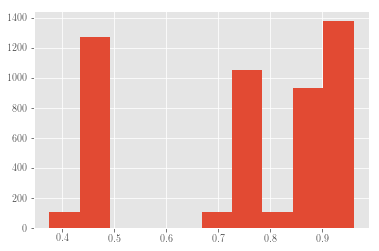

In [124]:
corr = lnn.correlation_matrix(s=1.)
plt.hist(corr[np.triu_indices(lnn.N, k=1)])

In [130]:
np.unique(corr[np.triu_indices(10, k=1)]).size

3

In [135]:
np.linalg.eigh(covar)

(array([ 112.        ,  112.        ,  112.        ,  112.        ,
         124.28870753,  352.        ,  352.        ,  352.        ,
         352.        , 1869.71129247]),
 array([[-2.98082412e-02,  9.10828362e-02,  6.52635716e-01,
         -6.04054640e-01,  4.37144619e-01,  0.00000000e+00,
          0.00000000e+00,  4.57863317e-17,  0.00000000e+00,
         -9.43640926e-02],
        [ 6.25279426e-02, -2.89264815e-01, -6.99885334e-01,
         -4.71780290e-01,  4.37144619e-01, -8.22274276e-17,
         -2.69240564e-16, -4.20831145e-16, -1.29195388e-17,
         -9.43640926e-02],
        [ 1.61292025e-01,  8.24762606e-01, -1.98089526e-01,
          2.33478193e-01,  4.37144619e-01,  6.43502768e-17,
          1.33379694e-16,  3.35977164e-16, -8.12041236e-17,
         -9.43640926e-02],
        [-7.86341171e-01, -1.87801694e-01,  3.63792664e-02,
          3.80886644e-01,  4.37144619e-01, -3.24981560e-16,
         -3.03966106e-17, -1.01203254e-16,  2.69657234e-16,
         -9.43640926e-0